In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logit
from scipy.stats import norm

import tensorflow as tf
from keras import layers, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Inspired by the concept of minimizing the length of a string as a form of regularization. 

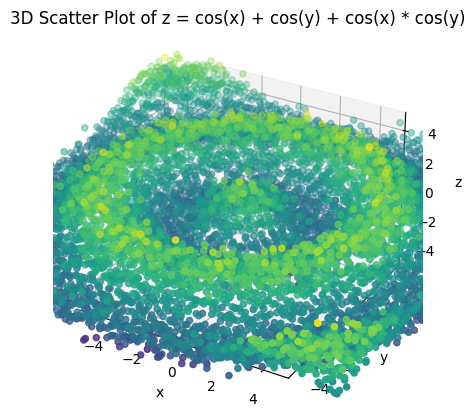

In [229]:
plt.ion()

x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
x, y = torch.meshgrid(x, y)
z = torch.cos(torch.sqrt(x ** 2 + y ** 2))

noise = torch.normal(mean=0, std=0.5, size=z.size())
z_noisy = z + noise

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])

ax.scatter(x.numpy(), y.numpy(), z_noisy.numpy(), c=z_noisy.numpy(), cmap='viridis', label='z = cos(x) + cos(y) + cos(x) * cos(y)')

ax.set_title("3D Scatter Plot of z = cos(x) + cos(y) + cos(x) * cos(y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

100,000 iterations because why not

Plot turned out quite nicely

In [378]:
learning_rate = 0.0005
smoothness_weight = 0.1
smoothness_second_weight = 0.5
optimized_tensor = torch.zeros_like(z_noisy, requires_grad=True)
num_iterations = 5000

loss_history = []

In [379]:
for i in range(num_iterations):
    data_loss = torch.sum((optimized_tensor - z_noisy) ** 2)

    first_diff_x = x[:-1, :] - x[1:, :]
    first_diff_y = y[:, :-1] - y[:, 1:]
    first_order_x = (optimized_tensor[1:, :] - optimized_tensor[:-1, :]) / first_diff_x
    first_order_y = (optimized_tensor[:, 1:] - optimized_tensor[:, :-1]) / first_diff_y

    second_diff_x = first_diff_x[:-1, :] - first_diff_x[1:, :]    
    second_diff_y = first_diff_y[:, :-1] - first_diff_y[:, 1:]
    second_order_x = (first_order_x[1:, :] - first_order_x[:-1, :])
    second_order_y = (first_order_y[:, 1:] - first_order_y[:, :-1])

    smoothness_loss = torch.sum(first_order_x ** 2) + torch.sum(first_order_y ** 2)
    second_smoothness_loss = torch.sum(second_order_x ** 2) + torch.sum(second_order_y ** 2)
    
    """
    could probably incorporate even higher-order information also
    """

    total_loss = data_loss + smoothness_weight * smoothness_loss + smoothness_second_weight * second_smoothness_loss
    total_loss.backward()
    
    with torch.no_grad():
        optimized_tensor -= learning_rate * optimized_tensor.grad
    
    optimized_tensor.grad.zero_()
    loss_history.append(total_loss.item())

print(optimized_tensor)

tensor([[0.0374, 0.1464, 0.2689,  ..., 0.4845, 0.3865, 0.3193],
        [0.1501, 0.2672, 0.3724,  ..., 0.5238, 0.4260, 0.3419],
        [0.2837, 0.3880, 0.4853,  ..., 0.5689, 0.4770, 0.3755],
        ...,
        [0.4505, 0.5387, 0.6235,  ..., 0.5057, 0.4374, 0.3527],
        [0.4027, 0.4866, 0.5702,  ..., 0.4194, 0.3407, 0.2707],
        [0.3769, 0.4623, 0.5249,  ..., 0.3333, 0.2523, 0.2040]],
       requires_grad=True)


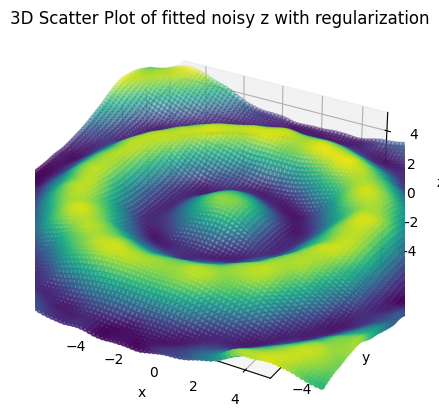

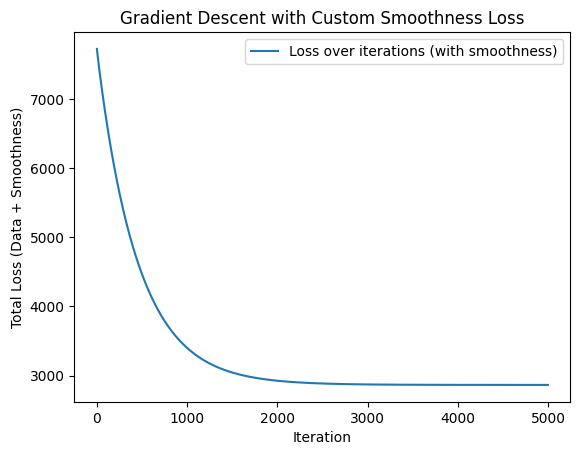

In [382]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])

ax.scatter(x.numpy().flatten(), y.numpy().flatten(), optimized_tensor.detach().numpy().flatten(), c=optimized_tensor.detach().numpy().flatten(), cmap='viridis', label='z = cos(x) + cos(y) + cos(x) * cos(y)')

ax.set_title("3D Scatter Plot of fitted noisy z with regularization")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

plt.plot(loss_history, label="Loss over iterations (with smoothness)")
plt.title("Gradient Descent with Custom Smoothness Loss")
plt.xlabel("Iteration")
plt.ylabel("Total Loss (Data + Smoothness)")
plt.legend()
plt.show()

In [383]:
squared_loss_y_noisy = torch.sum((z_noisy - z) ** 2)
squared_loss_optimized = torch.sum((optimized_tensor.detach() - z) ** 2)

squared_loss_y_noisy.item(), squared_loss_optimized.item()

(2478.8212890625, 92.97563171386719)